In [ ]:
!git clone https://github.com/VladPiatachenko/IEIT.git

Cloning into 'IEIT'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 6 (delta 1), reused 2 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (6/6), 5.27 KiB | 1.32 MiB/s, done.
Resolving deltas: 100% (1/1), done.


Dataset of sattelite images

In [1]:
!wget --no-check-certificate "https://drive.google.com/uc?export=download&id=1ACQbzra2uYt3xWgZ2-MhQgB2DnyRpv3A" -O dataset.zip


--2025-02-11 19:04:02--  https://drive.google.com/uc?export=download&id=1ACQbzra2uYt3xWgZ2-MhQgB2DnyRpv3A
Resolving drive.google.com (drive.google.com)... 74.125.134.101, 74.125.134.138, 74.125.134.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.134.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1ACQbzra2uYt3xWgZ2-MhQgB2DnyRpv3A&export=download [following]
--2025-02-11 19:04:02--  https://drive.usercontent.google.com/download?id=1ACQbzra2uYt3xWgZ2-MhQgB2DnyRpv3A&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2426 (2.4K) [text/html]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]   2.37K  --.-KB/s    in 0s      

2025

In [2]:
!pip install wandb


In [3]:
# Install gdown if not already installed
!pip install gdown

# Direct Google Drive file link and destination
file_id = "1ACQbzra2uYt3xWgZ2-MhQgB2DnyRpv3A"
destination = "dataset.zip"  # Name for the downloaded file

# Use gdown with a confirmation bypass flag
!gdown "https://drive.google.com/uc?export=download&id={file_id}" -O $destination


Downloading...
From (original): https://drive.google.com/uc?export=download&id=1ACQbzra2uYt3xWgZ2-MhQgB2DnyRpv3A
From (redirected): https://drive.google.com/uc?export=download&id=1ACQbzra2uYt3xWgZ2-MhQgB2DnyRpv3A&confirm=t&uuid=04bc88d8-f478-4581-9430-e8e511cf8f9e
To: /content/dataset.zip
100% 94.7M/94.7M [00:01<00:00, 57.2MB/s]


In [4]:
!unzip -q dataset.zip -d dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Завантаження даних
def load_images_from_directory(base_path, target_size=(64, 64), max_images_per_class=2000):
    data, labels, class_map = [], [], {}
    for idx, class_name in enumerate(sorted(os.listdir(base_path))):
        class_dir = os.path.join(base_path, class_name)
        if not os.path.isdir(class_dir) or class_name.startswith('.'):
            continue
        class_map[idx] = class_name
        print(f"Loading images for class: {class_name}")
        class_images = []
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = load_img(file_path, target_size=target_size, color_mode='grayscale')
                img_array = img_to_array(img) / 255.0
                class_images.append((img_array, idx))
                if len(class_images) >= max_images_per_class:
                    break
        for img_array, label in class_images:
            data.append(img_array)
            labels.append(label)
    return np.array(data), np.array(labels), class_map

# Модель CNN
def trainable_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(16, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Функція для бінаризації ознак
def binarize_features(features, thresholds):
    """
    Бінаризація ознак із використанням заданих порогів.

    features: np.array
        Матриця ознак (n_samples, n_features).
    thresholds: np.array
        Пороги для кожної ознаки (n_features,).

    Returns:
        np.array
        Бінаризована матриця ознак (0 або 1).
    """
    return (features > thresholds).astype(np.float32)

# Клас k-NN класифікатора
class KNNClassifier:
    def __init__(self, k=5, metric="hamming"):
        self.k = k
        self.metric = metric
        self.train_features = None
        self.train_labels = None

    def fit(self, train_features, train_labels):
        """
        Збереження навчальних даних (формування правил класифікатора).

        Parameters:
        train_features: np.array
            Ознаки для навчання (n_samples, n_features).
        train_labels: np.array
            Мітки класів для навчання (n_samples,).
        """
        self.train_features = train_features
        self.train_labels = train_labels

    def predict(self, test_features):
        """
        Розпізнавання (класифікація) тестових даних.

        Parameters:
        test_features: np.array
            Ознаки для тестування (n_samples, n_features).

        Returns:
        np.array
            Передбачені мітки класів для тестових даних.
        """
        if self.train_features is None or self.train_labels is None:
            raise ValueError("Класифікатор не було навчено. Використайте метод fit перед predict.")

        # Обчислення відстаней між тестовими та навчальними ознаками
        distances = pairwise_distances(test_features, self.train_features, metric=self.metric)
        predictions = []
        for dist in distances:
            # Знаходимо k найближчих сусідів
            k_indices = np.argsort(dist)[:self.k]
            k_labels = self.train_labels[k_indices]
            # Вибираємо найпоширеніший клас серед сусідів
            pred_label = np.argmax(np.bincount(k_labels))
            predictions.append(pred_label)
        return np.array(predictions)

if __name__ == "__main__":
    # Завантаження даних
    dataset_path = "/content/dataset/img"  # Змініть на ваш шлях до даних
    image_size = (64, 64)
    data, labels, class_map = load_images_from_directory(dataset_path, target_size=image_size)

    # Розподіл на навчальні та тестові набори
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=0.2, stratify=labels, random_state=42
    )

    # Додаємо канал (видаляємо зайвий вимір, якщо він існує)
    train_data = np.squeeze(train_data)
    test_data = np.squeeze(test_data)
    train_data = train_data[..., np.newaxis] if train_data.ndim == 3 else train_data
    test_data = test_data[..., np.newaxis] if test_data.ndim == 3 else test_data

    # Перевіряємо форми
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Навчання CNN
    cnn = trainable_cnn(image_size + (1,), len(class_map))
    cnn.fit(train_data, train_labels, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

    # Витягування ознак
    feature_extractor = Sequential(cnn.layers[:-2])  # Виключаємо останній шар класифікації
    feature_extractor.compile(optimizer='adam')  # Додамо, щоб уникнути помилок при використанні моделі

    # Передбачення ознак
    train_features = feature_extractor.predict(train_data, verbose=1)
    test_features = feature_extractor.predict(test_data, verbose=1)

    # Виведемо частину даних до бінаризації
    print("\n--- Дані до бінаризації (перші 2 рядки) ---")
    print(f"Train features (до бінаризації):\n{train_features[:2]}")
    print(f"Test features (до бінаризації):\n{test_features[:2]}")

    # Розрахунок порогів на основі навчальних даних
    thresholds = np.mean(train_features, axis=0)  # Або np.median(train_features, axis=0)
    print(f"\nАдаптивні пороги для ознак (на основі навчальних даних):\n{thresholds}")

    # Бінаризація ознак
    train_features = binarize_features(train_features, thresholds)
    test_features = binarize_features(test_features, thresholds)

    # Виведемо частину даних після бінаризації
    print("\n--- Дані після бінаризації (перші 2 рядки) ---")
    print(f"Train features (після бінаризації):\n{train_features[:2]}")
    print(f"Test features (після бінаризації):\n{test_features[:2]}")

    # 1. Формування правил класифікатора (навчання)
    knn = KNNClassifier(k=5, metric="hamming")
    knn.fit(train_features, train_labels)

    # 2. Розпізнавання тестових даних
    predicted_labels = knn.predict(test_features)

    # Оцінка точності
    accuracy = np.mean(predicted_labels == test_labels)
    print(f"\nAccuracy: {accuracy:.2f}")

    # Показуємо деякі результати
    print("\nSample predictions:")
    for i in range(10):
        true_label = class_map[test_labels[i]]
        predicted_label = class_map[predicted_labels[i]]
        print(f"Test Image {i}: True Label = {true_label}, Predicted Label = {predicted_label}")


In [5]:
import os
os.environ["WANDB_API_KEY"] = "702974ffffd1c7f8266ee536bff2d56f1d78a73a"

In [10]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import wandb
from wandb.integration.keras import WandbCallback


# ✅ Initialize Weights & Biases
wandb.init(
    project="IExNet",
    config={
        "epochs": 30,
        "batch_size": 32,
        "architecture": "CNN + IEIT",
        "dataset": "EuroSAT_RGB",
        "image_size": (64, 64),
    },
    settings=wandb.Settings(init_timeout=180)  # ⬅️ Increased timeout to 180 sec
)


# ✅ Load dataset
def load_images_from_directory(base_path, target_size=(64, 64), max_images_per_class=2000):
    data, labels, class_map = [], [], {}
    class_counts = {}

    for idx, class_name in enumerate(sorted(os.listdir(base_path))):
        class_dir = os.path.join(base_path, class_name)
        if not os.path.isdir(class_dir) or class_name.startswith('.'):
            continue
        class_map[idx] = class_name
        class_counts[class_name] = 0

        class_images = []
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = load_img(file_path, target_size=target_size, color_mode='grayscale')
                img_array = img_to_array(img) / 255.0
                class_images.append((img_array, idx))
                class_counts[class_name] += 1
                if len(class_images) >= max_images_per_class:
                    break

        for img_array, label in class_images:
            data.append(img_array)
            labels.append(label)

    return np.array(data), np.array(labels), class_map

# ✅ CNN Model
def trainable_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # ✅ FIXED softmax activation
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# ✅ Load dataset
dataset_path = "/content/dataset/EuroSAT_RGB"
image_size = (64, 64)
data, labels, class_map = load_images_from_directory(dataset_path, target_size=image_size)

# ✅ Train-test split
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42
)

# ✅ Log sample images to WandB
wandb.log({
    "sample_images": [wandb.Image(train_data[i], caption=class_map[train_labels[i]]) for i in range(10)]
})

# ✅ Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
test_labels = label_encoder.transform(test_labels)
class_map = {idx: name for idx, name in enumerate(label_encoder.classes_)}

# ✅ Expand dimensions if necessary
train_data = np.squeeze(train_data)
test_data = np.squeeze(test_data)
train_data = train_data[..., np.newaxis] if train_data.ndim == 3 else train_data
test_data = test_data[..., np.newaxis] if test_data.ndim == 3 else test_data

# ✅ Train CNN model
cnn = trainable_cnn(image_size + (1,), len(class_map))
cnn.fit(
    train_data, train_labels,
    epochs=30, batch_size=32,
    validation_split=0.2, verbose=1,
    callbacks=[WandbCallback(log_batch_frequency=10, save_graph=False, save_model=False)]
)


# ✅ Extract features
feature_extractor = Sequential(cnn.layers[:-2])
feature_extractor.compile(optimizer='adam')

train_features = feature_extractor.predict(train_data, verbose=1)
test_features = feature_extractor.predict(test_data, verbose=1)

# ✅ Convert features to binary
thresholds = np.mean(train_features, axis=0)
train_features = (train_features > thresholds).astype(np.float32)
test_features = (test_features > thresholds).astype(np.float32)

# ✅ Train IEIT Classifier
class IEITClassifier:
    def __init__(self):
        self.train_features = None
        self.train_labels = None
        self.class_means = None

    def fit(self, train_features, train_labels):
        self.train_features = train_features
        self.train_labels = train_labels
        unique_classes = np.unique(train_labels)

        self.class_means = []
        for class_label in unique_classes:
            class_features = train_features[train_labels == class_label]
            class_mean = np.mean(class_features, axis=0)
            self.class_means.append((class_mean >= 0.5).astype(int))
        self.class_means = np.array(self.class_means)

    def predict(self, test_vector):
        best_class = None
        best_distance = float('inf')

        for class_label, mean_vector in enumerate(self.class_means):
            distance = np.sum(test_vector != mean_vector)
            if distance < best_distance:
                best_distance = distance
                best_class = class_label

        return best_class

ieit = IEITClassifier()
ieit.fit(train_features, train_labels)

# ✅ Predict test data
predicted_labels = np.array([ieit.predict(test_vector) for test_vector in test_features])

# ✅ Calculate accuracy
accuracy = np.mean(predicted_labels == test_labels)
print(f"\nAccuracy: {accuracy:.2f}")

# ✅ Log accuracy to WandB
wandb.log({"accuracy": accuracy})

# ✅ Sample predictions
print("\nSample predictions:")
for i in range(10):
    true_label = class_map[test_labels[i]]
    predicted_label = class_map[predicted_labels[i]]
    print(f"Test Image {i}: True Label = {true_label}, Predicted Label = {predicted_label}")


Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 783ms/step - accuracy: 0.3973 - loss: 1.3754 - val_accuracy: 0.6510 - val_loss: 0.8219
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 196s 817ms/step - accuracy: 0.7466 - loss: 0.6817 - val_accuracy: 0.8000 - val_loss: 0.5327
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 194s 783ms/step - accuracy: 0.8018 - loss: 0.5430 - val_accuracy: 0.8432 - val_loss: 0.4487
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 201s 781ms/step - accuracy: 0.8263 - loss: 0.4770 - val_accuracy: 0.7901 - val_loss: 0.5770
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 189s 787ms/step - accuracy: 0.8399 - loss: 0.4321 - val_accuracy: 0.8755 - val_loss: 0.3294
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 796ms/step - accuracy: 0.8641 - loss: 0.3654 - val_accuracy: 0.8490 - val_loss: 0.4117
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 209s 829ms/step - accuracy: 0.8625 - loss: 0.3790 - val_accuracy: 0.7818 - val_loss: 0.6272
Epoch 8/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 202s 829ms/step - accuracy: 0.8621 -

token:702974ffffd1c7f8266ee536bff2d56f1d78a73a


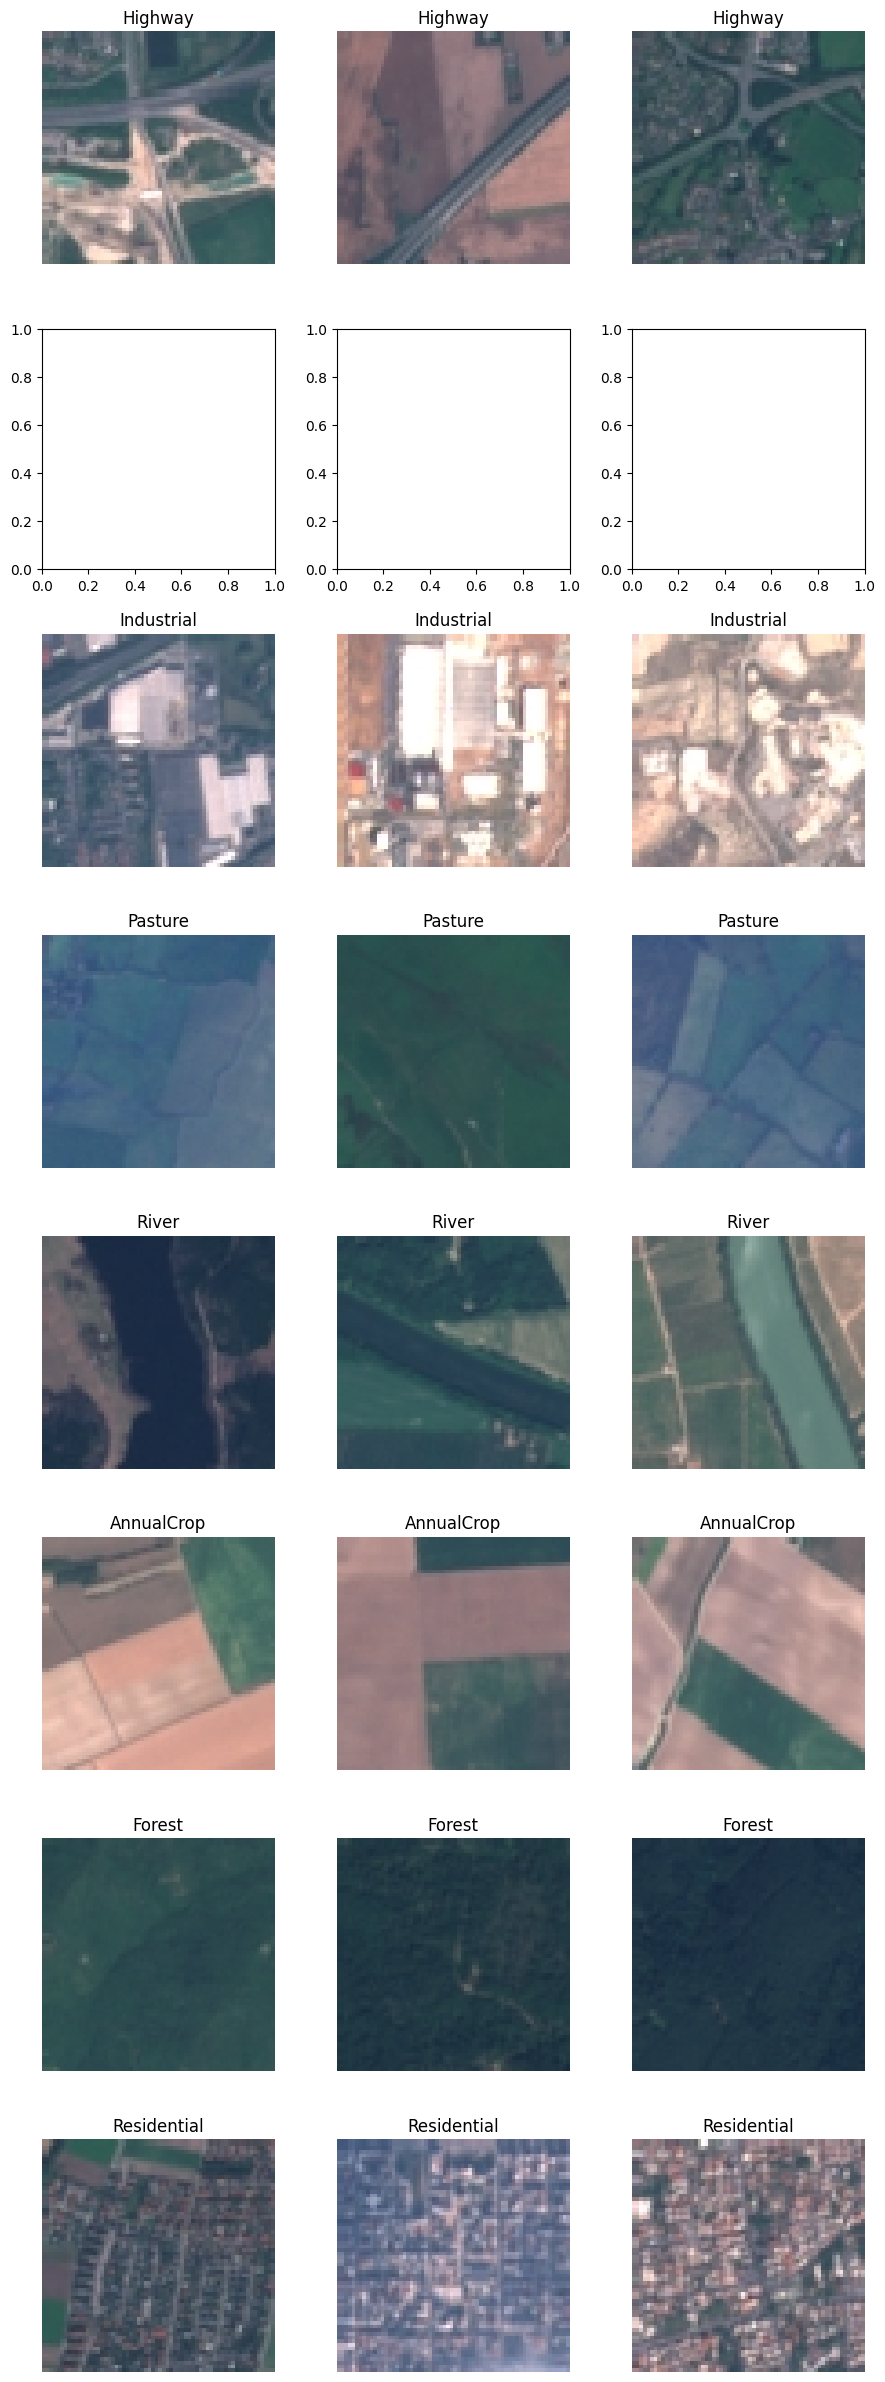

In [12]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# 🔹 Шлях до датасету
dataset_path = "/content/dataset/EuroSAT_RGB"

# 🔹 Скільки картинок показати з кожного класу
num_images_per_class = 3

# Отримуємо список класів (папок)
class_names = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]

# Виведемо по кілька зображень з кожного класу
fig, axes = plt.subplots(len(class_names), num_images_per_class, figsize=(num_images_per_class * 3, len(class_names) * 3))

for row, class_name in enumerate(class_names):
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Випадково вибираємо зображення
    selected_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

    for col, image_file in enumerate(selected_images):
        img_path = os.path.join(class_path, image_file)
        img = load_img(img_path)  # Завантажуємо зображення

        axes[row, col].imshow(img)
        axes[row, col].axis("off")
        axes[row, col].set_title(class_name)

# Відображаємо результати
plt.tight_layout()
plt.show()


In [ ]:
import os
import numpy as np
from sklearn.metrics import pairwise_distances
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dropout
import wandb
from wandb.integration.keras import WandbCallback


# ✅ Initialize Weights & Biases
wandb.init(
    project="IExNet",
    config={
        "epochs": 30,
        "batch_size": 32,
        "architecture": "CNN + IEIT",
        "dataset": "EuroSAT_RGB",
        "image_size": (64, 64),
    },
    settings=wandb.Settings(init_timeout=180)  # ⬅️ Increased timeout to 180 sec
)

# Завантаження даних
def load_images_from_directory(base_path, target_size=(64, 64), max_images_per_class=2000):
    data, labels, class_map = [], [], {}
    class_counts = {}  # Для підрахунку зображень у кожному класі

    for idx, class_name in enumerate(sorted(os.listdir(base_path))):
        class_dir = os.path.join(base_path, class_name)
        if not os.path.isdir(class_dir) or class_name.startswith('.'):
            continue
        class_map[idx] = class_name
        class_counts[class_name] = 0  # Лічильник для кожного класу
        print(f"Loading images for class: {class_name}")

        class_images = []
        for file_name in os.listdir(class_dir):
            file_path = os.path.join(class_dir, file_name)
            if file_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = load_img(file_path, target_size=target_size, color_mode='grayscale')
                img_array = img_to_array(img) / 255.0
                class_images.append((img_array, idx))
                class_counts[class_name] += 1  # Збільшуємо лічильник
                if len(class_images) >= max_images_per_class:
                    break

        for img_array, label in class_images:
            data.append(img_array)
            labels.append(label)

    print("\n--- Завантажені зображення по класах ---")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} зображень")

    return np.array(data), np.array(labels), class_map


# Модель CNN
def trainable_cnn(input_shape, num_classes):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),  # 🔹 Вимикаємо 20% нейронів
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),  # 🔹 Вимикаємо 30% нейронів
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.4),  # 🔹 Вимикаємо 40% нейронів
        Conv2D(512, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.5),  # 🔹 Вимикаємо 50% нейронів
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # 🔹 Останній рівень Dropout
        Dense(num_classes, activation='linear')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model



# Функція для бінаризації ознак
def binarize_features(features, thresholds):
    """
    Бінаризація ознак із використанням заданих порогів.

    features: np.array
        Матриця ознак (n_samples, n_features).
    thresholds: np.array
        Пороги для кожної ознаки (n_features,).

    Returns:
        np.array
        Бінаризована матриця ознак (0 або 1).
    """
    return (features > thresholds).astype(np.float32)

class IEITClassifier:
    def __init__(self):
        self.train_features = None
        self.class_means = None
        self.distance_matrix = None
        self.closest_pairs = None
        self.optimal_radii = {}  # Оптимальні радіуси для кожного класу

    def fit(self, train_features, train_labels):
        """
        Form rules for the classifier:
        - Compute binary mean vectors for each class
        - Find the closest class for each class
        - Compute reliability and error parameters for each radius
        """
        self.train_features = train_features
        self.train_labels = train_labels  # 🔴 STORE train_labels HERE

        unique_classes = np.unique(train_labels)

        # Compute binary mean vectors for each class
        self.class_means = []
        for class_label in unique_classes:
            class_features = train_features[train_labels == class_label]
            class_mean = np.mean(class_features, axis=0)
            binary_class_mean = (class_mean >= 0.5).astype(int)
            self.class_means.append(binary_class_mean)
        self.class_means = np.array(self.class_means)

        # Compute distance matrix
        self.distance_matrix = self.calculate_distance_matrix(self.class_means)

        # Find closest class for each class
        self.closest_pairs = self.find_all_closest_pairs(self.distance_matrix)

        # Compute reliability and error
        self.compute_reliability_and_error()

    @staticmethod
    def hamming_distance(vector1, vector2):
        """Розраховує гаммінгову відстань між двома бінарними векторами"""
        return np.sum(vector1 != vector2)

    def calculate_distance_matrix(self, class_means):
        """Створює матрицю гаммінгових відстаней між класами"""
        num_classes = class_means.shape[0]
        distance_matrix = np.zeros((num_classes, num_classes))
        for i in range(num_classes):
            for j in range(i + 1, num_classes):
                distance = self.hamming_distance(class_means[i], class_means[j])
                distance_matrix[i, j] = distance
                distance_matrix[j, i] = distance
        return distance_matrix

    def find_all_closest_pairs(self, distance_matrix):
        """Для кожного класу знаходить найближчий до нього клас"""
        num_classes = distance_matrix.shape[0]
        closest_pairs = {}
        for i in range(num_classes):
            distances = distance_matrix[i].copy()
            distances[i] = np.inf  # Ігноруємо відстань до самого себе
            closest_class = np.argmin(distances)
            closest_pairs[i] = closest_class
        return closest_pairs

    def compute_Jm(self, K1, K3):
        """
        Обчислення Jm згідно з формулою.
        """
        n = 1  # Припущення рівноімовірності
        r = 3
        epsilon = 10**(-r)  # Дуже мале число для стабілізації

        numerator = (2 * n + epsilon - (1 - K1 + K3))
        denominator = (1 - K1 + K3 + epsilon)

        if denominator == 0:
            return float('-inf')  # Запобігання діленню на 0

        log_term = np.log2(numerator / denominator)

        Jm = (1 / n) * log_term * (n - (1 - K1 + K3))

        return Jm


    def compute_reliability_and_error(self, output_dir="radius_logs"):
        """
        Computes reliability and error for each class and writes results to a file.
        Each class gets a separate log file.
        """
        num_features = self.train_features.shape[1]  # Number of features
        unique_classes = range(len(self.class_means))

        os.makedirs(output_dir, exist_ok=True)  # Create output directory if not exists

        print("\n--- Calculating reliability and error for each radius ---")

        for class_label in unique_classes:
            neighbor_class_label = self.closest_pairs[class_label]
            mean_vector = self.class_means[class_label]

            class_vectors = self.train_features[np.where(self.train_labels == class_label)]
            neighbor_vectors = self.train_features[np.where(self.train_labels == neighbor_class_label)]

            optimal_radius = None

            log_filename = os.path.join(output_dir, f"class_{class_label}_radius_log.txt")

            with open(log_filename, "w") as log_file:
                log_file.write(f"Class {class_label} (Closest class: {neighbor_class_label})\n")
                log_file.write("Radius | k1 | k2 | Reliability | Beta Error | Jm | Optimal\n")
                log_file.write("-" * 80 + "\n")

                for radius in range(1, num_features + 1):
                    distances_self = np.array([self.hamming_distance(mean_vector, vec) for vec in class_vectors])
                    distances_neighbor = np.array([self.hamming_distance(mean_vector, vec) for vec in neighbor_vectors])

                    k1 = np.sum(distances_self <= radius)
                    k2 = np.sum(distances_neighbor <= radius)

                    reliability = k1 / len(class_vectors)
                    beta_error = k2 / len(neighbor_vectors)

                    is_optimal = reliability > 0.5 and beta_error < 0.5

                    if is_optimal:
                        optimal_radius = radius

                    kfe = self.compute_Jm(reliability, beta_error)

                    log_file.write(f"{radius:5d} | {k1:4d} | {k2:4d} | {reliability:.3f} | {beta_error:.3f} | {kfe:.3f} | {is_optimal}\n")

            self.optimal_radii[class_label] = optimal_radius
            print(f"✅ Log saved for class {class_label}: {log_filename}")

        print("\n--- Optimal Radii for Each Class ---")
        for class_label, radius in self.optimal_radii.items():
            print(f"Class {class_label}: Optimal Radius = {radius}")


    def predict(self, test_vector):
        """
        Передбачення одного вектора.

        Parameters:
        test_vector: np.array
            Вхідний вектор ознак (бінаризований).

        Returns:
        class_prediction: int
            Найбільш ймовірний клас.
        """
        best_score = None
        best_class = None

        print("\n--- Процес розпізнавання ---")

        for class_label, mean_vector in enumerate(self.class_means):
            if class_label not in self.optimal_radii or self.optimal_radii[class_label] is None:
                print(f"Клас {class_label} пропущений: немає оптимального радіуса")
                continue  # Пропускаємо, якщо немає оптимального радіуса

            radius = self.optimal_radii[class_label]
            distance = self.hamming_distance(mean_vector, test_vector)

            if radius == 0:  # Уникаємо ділення на нуль
                print(f"Клас {class_label} пропущений: радіус = 0")
                continue

            score = 1 - (distance / radius)

            print(f"Клас {class_label}: Відстань={distance}, Радіус={radius}, f={score:.3f}")

            if best_score is None or score > best_score:
                best_score = score
                best_class = class_label

        return best_class


if __name__ == "__main__":
    # Завантаження даних
    dataset_path = "/content/dataset/EuroSAT_RGB"  # Шлях до даних
    image_size = (64, 64)
    data, labels, class_map = load_images_from_directory(dataset_path, target_size=image_size)

    # Розподіл на навчальні та тестові набори
    train_data, test_data, train_labels, test_labels = train_test_split(
        data, labels, test_size=0.2, stratify=labels, random_state=42
    )

  ### 🔹 ДОДАНО: Перекодування міток у послідовний діапазон 0, 1, 2, ..., num_classes-1
    label_encoder = LabelEncoder()
    train_labels = label_encoder.fit_transform(train_labels)
    test_labels = label_encoder.transform(test_labels)

    ### 🔹 ДОДАНО: Оновлення class_map (індекси класів → назви)
    class_map = {idx: name for idx, name in enumerate(label_encoder.classes_)}
    print(f"Оновлений class_map: {class_map}")  # Переконайтеся, що класи правильні

    # 🔹 Оновлення кількості класів
    num_classes = len(np.unique(train_labels))
    print(f"Кількість класів після перекодування: {num_classes}")  # Має бути 7
    # Додаємо канал (видаляємо зайвий вимір, якщо він існує)
    train_data = np.squeeze(train_data)
    test_data = np.squeeze(test_data)
    train_data = train_data[..., np.newaxis] if train_data.ndim == 3 else train_data
    test_data = test_data[..., np.newaxis] if test_data.ndim == 3 else test_data

    # Перевіряємо форми
    print(f"Train data shape: {train_data.shape}")
    print(f"Test data shape: {test_data.shape}")

    # Навчання CNN
    cnn = trainable_cnn(image_size + (1,), len(class_map))
    cnn.fit(train_data, train_labels, epochs=30, batch_size=32, validation_split=0.2, verbose=1)

    # Витягування ознак
    feature_extractor = Sequential(cnn.layers[:-2])  # Виключаємо останній шар класифікації
    feature_extractor.compile(optimizer='adam')

    # Передбачення ознак
    train_features = feature_extractor.predict(train_data, verbose=1)
    test_features = feature_extractor.predict(test_data, verbose=1)

    # Виведемо частину даних до бінаризації
    print("\n--- Дані до бінаризації (перші 2 рядки) ---")
    print(f"Train features (до бінаризації):\n{train_features[:2]}")
    print(f"Test features (до бінаризації):\n{test_features[:2]}")

    # Розрахунок порогів на основі навчальних даних
    thresholds = np.mean(train_features, axis=0)  # Або np.median(train_features, axis=0)
    print(f"\nАдаптивні пороги для ознак (на основі навчальних даних):\n{thresholds}")

    # Бінаризація ознак
    train_features = binarize_features(train_features, thresholds)
    test_features = binarize_features(test_features, thresholds)

    # Виведемо частину даних після бінаризації
    print("\n--- Дані після бінаризації (перші 2 рядки) ---")
    print(f"Train features (після бінаризації):\n{train_features[:2]}")
    print(f"Test features (після бінаризації):\n{test_features[:2]}")

    # 1. Формування правил класифікатора (навчання)
    ieit = IEITClassifier()
    ieit.fit(train_features, train_labels)

    # 2. Розпізнавання тестових даних
    predicted_labels = np.array([ieit.predict(test_vector) for test_vector in test_features])

    # Оцінка точності
    accuracy = np.mean(predicted_labels == test_labels)
    print(f"\nAccuracy: {accuracy:.2f}")

    # Показуємо деякі результати
    print("\nSample predictions:")
    for i in range(10):
        true_label = class_map[test_labels[i]]
        predicted_label = class_map[predicted_labels[i]]  # Оновлено доступ до класу
        print(f"Test Image {i}: True Label = {true_label}, Predicted Label = {predicted_label}")

Loading images for class: AnnualCrop
Loading images for class: Forest
Loading images for class: Highway
Loading images for class: Industrial
Loading images for class: Pasture
Loading images for class: Residential

--- Завантажені зображення по класах ---
AnnualCrop: 2000 зображень
Forest: 2000 зображень
Highway: 2000 зображень
Industrial: 2000 зображень
Pasture: 2000 зображень
Residential: 2000 зображень
Оновлений class_map: {0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6}
Кількість класів після перекодування: 6
Train data shape: (9600, 64, 64, 1)
Test data shape: (2400, 64, 64, 1)
Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 199s 816ms/step - accuracy: 0.1761 - loss: 3.1790 - val_accuracy: 0.1682 - val_loss: 1.7918
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 191s 772ms/step - accuracy: 0.1653 - loss: 5.2710 - val_accuracy: 0.1714 - val_loss: 6.5155
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 202s 772ms/step - accuracy: 0.1737 - loss: 6.9013 - val_accuracy: 0.1698 - val_loss: 6.5155
Epoch 4/30
240/240 ━━━━━━━━